In [21]:
import classes_taskonomy as classes

# modified visualpriors library
from transforms import VisualPriorRepresentation

import os
import pandas as pd

import torch.utils.model_zoo # required to load nets
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

In [3]:
DATASET_NAMES = ('places1', 'places2', 'oasis')
SCALE_NAMES = ('scale2','scale4','scale8','scale16','scale32')

In [4]:
DATA_PATH = './data_256x256'
BEHAVIOR_PATH = './behavior'
RESULTS_PATH = './results_taskonomy'

In [5]:
#VisualPrior.viable_feature_tasks
MODEL_NAMES = ('autoencoding','depth_euclidean','jigsaw','reshading',
               'edge_occlusion','keypoints2d','room_layout', #'colorization' currently not working
               'curvature','edge_texture','keypoints3d','segment_unsup2d',
               'class_object','egomotion','nonfixated_pose','segment_unsup25d',
               'class_scene','fixated_pose','normal','segment_semantic',
               'denoising','inpainting','point_matching','vanishing_point')


In [5]:
IMAGE_TRANSFORMS = ('untransformed')

# create folder structure

In [11]:
# create folder structure for image
for dataset_name in DATASET_NAMES:
    for scale_name in SCALE_NAMES:
        for version_name in ('full','version1','version2'):
            os.makedirs(os.path.join(DATA_PATH, dataset_name, scale_name, version_name))

In [9]:
# create folder structure for results
for model_name in MODEL_NAMES:
    for dataset_name in DATASET_NAMES:
        for scale_name in SCALE_NAMES:
            dir_path = os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name)
            os.makedirs(dir_path)

In [7]:
# create folder strucutre for Pytorch -> Matlab converted results
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join('../matlab analysis', 'data taskonomy', model_name))


# model analysis

In [6]:
for model_name in MODEL_NAMES:
    print(model_name)

    # Import taskonomy model...
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]
    
    # ...and create activation extractor from it
    _, eval_nodes = get_graph_node_names(net)
    return_nodes = { node:node for node in eval_nodes if "conv" in node or 'fc' in node}
    activation_extractor = create_feature_extractor(net, return_nodes=return_nodes)


    for dataset_name in DATASET_NAMES:
        print(dataset_name)

        for scale_name in SCALE_NAMES:
            
            dataset = classes.ImageDataset(
                os.path.join(DATA_PATH, dataset_name, scale_name))
                        
            correlations, selfsimilarity, l2norm = classes.calculate_dataset_metrics(dataset, activation_extractor)
            
            correlations.fillna(correlations.mean())
            selfsimilarity.fillna(selfsimilarity.mean())
            l2norm.fillna(l2norm.mean())
            
            correlations.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'correlations.csv'), index=False, header=False)
            selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

autoencoding
places1


/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/max/minico

places2
oasis
depth_euclidean
places1
places2
oasis
jigsaw
places1
places2
oasis
reshading
places1
places2
oasis
edge_occlusion
places1
places2
oasis
keypoints2d
places1
places2
oasis
room_layout
places1
places2
oasis
curvature
places1
places2
oasis
edge_texture
places1
places2
oasis
keypoints3d
places1
places2
oasis
segment_unsup2d
places1
places2
oasis
class_object
places1
places2
oasis
egomotion
places1
places2
oasis
nonfixated_pose
places1
places2
oasis
segment_unsup25d
places1
places2
oasis
class_scene
places1
places2
oasis
fixated_pose
places1
places2
oasis
normal
places1
places2
oasis
segment_semantic
places1
places2
oasis
denoising
places1
places2
oasis
inpainting
places1
places2
oasis
point_matching
places1
places2
oasis
vanishing_point
places1
places2
oasis


# inspect results

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


In [33]:
# load results

data_list = []


for model_name in MODEL_NAMES:
    for dataset_name in DATASET_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'correlations.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'dataset',dataset_name)
            data.insert(0, 'model', model_name)

            data_list.append(data)
            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

df = - pd.concat(data_list).set_index(['model','dataset','scale'])

In [ ]:
# TODO
Raw integration values
Import blocked results
Group by scale

In [34]:
df

0         1         2         3   \
model           dataset scale                                             
autoencoding    places1 scale2  -0.999991 -0.980150 -0.934078 -0.950373   
                        scale2  -0.999955 -0.987940 -0.853927 -0.882959   
                        scale2  -0.999948 -0.985972 -0.816645 -0.844314   
                        scale2  -0.999968 -0.984580 -0.902988 -0.916636   
                        scale2  -0.999962 -0.980308 -0.865958 -0.881977   
...                                   ...       ...       ...       ...   
vanishing_point oasis   scale32 -0.999956 -0.736979 -0.673799 -0.526840   
                        scale32 -0.999994 -0.559089 -0.519985 -0.297355   
                        scale32 -0.999986 -0.745100 -0.731699 -0.580535   
                        scale32 -0.999987 -0.481061 -0.533987 -0.457241   
                        scale32 -0.999964 -0.875793 -0.891535 -0.826958   

                                       4         5         6         7   \
model           dataset scale                                             
autoencoding    places1 scale2  -0.946267 -0.968589 -0.978668 -0.950288   
                        scale2  -0.916863 -0.944056 -0.953189 -0.933913   
                        scale2  -0.913455 -0.911689 -0.936459 -0.925725   
                        scale2  -0.928993 -0.953318 -0.965490 -0.943280   
                        scale2  -0.932485 -0.933613 -0.947712 -0.940586   
...                                   ...       ...       ...       ...   
vanishing_point oasis   scale32 -0.607299 -0.707614 -0.651883 -0.668758   
                        scale32 -0.417353 -0.566333 -0.496001 -0.574783   
                        scale32 -0.622249 -0.736262 -0.665095 -0.708760   
                        scale32 -0.254065 -0.408789 -0.431091 -0.489067   
                        scale32 -0.790782 -0.876380 -0.830658 -0.849762   

                                       8         9   ...        39        40  \
model           dataset scale                        ...                       
autoencoding    places1 scale2  -0.952684 -0.932910  ... -0.999615 -0.949053   
                        scale2  -0.918589 -0.895599  ... -0.965302 -0.991503   
                        scale2  -0.914897 -0.871869  ... -0.956005 -0.992967   
                        scale2  -0.939263 -0.912893  ... -0.999572 -0.967323   
                        scale2  -0.936447 -0.899249  ... -0.953693 -0.991218   
...                                   ...       ...  ...       ...       ...   
vanishing_point oasis   scale32 -0.715317 -0.550742  ... -0.502281 -0.799934   
                        scale32 -0.624329 -0.395257  ... -0.446191 -0.795241   
                        scale32 -0.751446 -0.581870  ... -0.399687 -0.816461   
                        scale32 -0.547219 -0.339706  ... -0.374941 -0.711398   
                        scale32 -0.872600 -0.738045  ... -0.747368 -0.898107   

                                       41        42        43        44  \
model           dataset scale                                             
autoencoding    places1 scale2  -0.948992 -0.989634 -0.939210 -0.856485   
                        scale2  -0.867744 -0.756060 -0.880433 -0.484396   
                        scale2  -0.864104 -0.778778 -0.868949 -0.427199   
                        scale2  -0.914013 -0.963653 -0.887173 -0.580693   
                        scale2  -0.859319 -0.783753 -0.879696 -0.440225   
...                                   ...       ...       ...       ...   
vanishing_point oasis   scale32 -0.856914 -0.664586 -0.795413 -0.780625   
                        scale32 -0.814085 -0.622042 -0.733100 -0.715691   
                        scale32 -0.850732 -0.628190 -0.772020 -0.758465   
                        scale32 -0.743400 -0.471179 -0.617615 -0.587472   
                        scale32 -0.922974 -0.831362 -0.858689 -0.823223   

                                       45        46        47        4

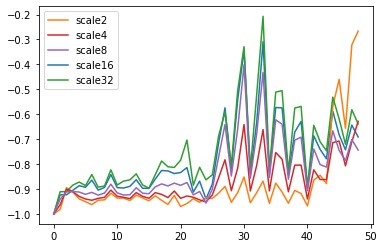

In [31]:
handles, labels = df.loc['autoencoding'].groupby('scale').mean().transpose().plot().get_legend_handles_labels()
order = [1, 3, 4, 0, 2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

In [46]:
with PdfPages('Mean integration per model') as pdf:
    for model_name in MODEL_NAMES:
        df.loc[model_name].groupby('scale').std().transpose().plot()
        plt.title(model_name)
        plt.ylim((-1,1))
        pdf.savefig()
        plt.clf() 

/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opene

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [40]:
df.loc[:,'places1',:]#.groupby('scale')

0         1         2         3         4   \
model           scale                                                       
autoencoding    scale2  -0.999991 -0.980150 -0.934078 -0.950373 -0.946267   
                scale2  -0.999955 -0.987940 -0.853927 -0.882959 -0.916863   
                scale2  -0.999948 -0.985972 -0.816645 -0.844314 -0.913455   
                scale2  -0.999968 -0.984580 -0.902988 -0.916636 -0.928993   
                scale2  -0.999962 -0.980308 -0.865958 -0.881977 -0.932485   
...                           ...       ...       ...       ...       ...   
vanishing_point scale32 -0.999981 -0.813512 -0.819203 -0.709399 -0.758775   
                scale32 -0.999970 -0.742673 -0.735190 -0.615017 -0.605645   
                scale32 -0.999984 -0.541142 -0.542664 -0.409767 -0.436615   
                scale32 -0.999914 -0.884498 -0.876986 -0.794655 -0.780816   
                scale32 -0.999940 -0.684757 -0.640973 -0.529267 -0.479246   

                               5         6         7         8         9   \
model           scale                                                       
autoencoding    scale2  -0.968589 -0.978668 -0.950288 -0.952684 -0.932910   
                scale2  -0.944056 -0.953189 -0.933913 -0.918589 -0.895599   
                scale2  -0.911689 -0.936459 -0.925725 -0.914897 -0.871869   
                scale2  -0.953318 -0.965490 -0.943280 -0.939263 -0.912893   
                scale2  -0.933613 -0.947712 -0.940586 -0.936447 -0.899249   
...                           ...       ...       ...       ...       ...   
vanishing_point scale32 -0.862275 -0.818641 -0.824868 -0.859281 -0.716411   
                scale32 -0.702987 -0.667852 -0.703710 -0.744867 -0.606241   
                scale32 -0.600144 -0.540669 -0.601464 -0.624811 -0.370253   
                scale32 -0.855630 -0.799448 -0.858404 -0.858864 -0.730134   
                scale32 -0.546124 -0.570701 -0.612281 -0.653548 -0.504684   

                         ...        39        40        41        42  \
model           scale    ...                                           
autoencoding    scale2   ... -0.999615 -0.949053 -0.948992 -0.989634   
                scale2   ... -0.965302 -0.991503 -0.867744 -0.756060   
                scale2   ... -0.956005 -0.992967 -0.864104 -0.778778   
                scale2   ... -0.999572 -0.967323 -0.914013 -0.963653   
                scale2   ... -0.953693 -0.991218 -0.859319 -0.783753   
...                      ...       ...       ...       ...       ...   
vanishing_point scale32  ... -0.598325 -0.889548 -0.929540 -0.811043   
                scale32  ... -0.385895 -0.739311 -0.814679 -0.585723   
                scale32  ... -0.424645 -0.760833 -0.814191 -0.629557   
                scale32  ... -0.928934 -0.914194 -0.932818 -0.863736   
                scale32  ... -0.474017 -0.813201 -0.851423 -0.685275   

                               43        44        45        46        47  \
model           scale                                                       
autoencoding    scale2  -0.939210 -0.856485 -0.971166 -0.933427 -0.771640   
                scale2  -0.880433 -0.484396 -0.337749 -0.554580 -0.201300   
                scale2  -0.868949 -0.427199 -0.277702 -0.537911 -0.161150   
                scale2  -0.887173 -0.580693 -0.595628 -0.659078 -0.252668   
                scale2  -0.879696 -0.440225 -0.293310 -0.588997 -0.198950   
...                           ...       ...       ...       ...       ...   
vanishing_point scale32 -0.903984 -0.901903 -0.824359 -0.965023 -0.894849   
                scale32 -0.703987 -0.716752 -0.604515 -0.816112 -0.695414   
                scale32 -0.724080 -0.683239 -0.556172 -0.848326 -0.648642   
                scale32 -0.839065 -0.833095 -0.763123 -0.925512 -0.834290   
                scale32 -0.758510 -0.697234 -0.583951 -0.885696 -0.723191   

                               48  
model           scale              
autoencoding    

# Linear modelling

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut


X = StandardScaler().fit_transform(result)
y = StandardScaler().fit_transform(pd.DataFrame(places_images.beauty_ratings))
X.shape, y.shape
loo, predictions = LeaveOneOut(), []

for train_idx, predict_idx in loo.split(X):
    glm = LinearRegression().fit(X[train_idx], y[train_idx])
    predictions.append(glm.predict(X[predict_idx]).item())

predictions = pd.Series(predictions)

pearsonr(predictions, places_images.beauty_ratings)